<a href="https://colab.research.google.com/github/acesur/Machine-Learning-/blob/main/01_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive/
Total number of images: 10015
Distribution of diagnostic categories:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

Missing values:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


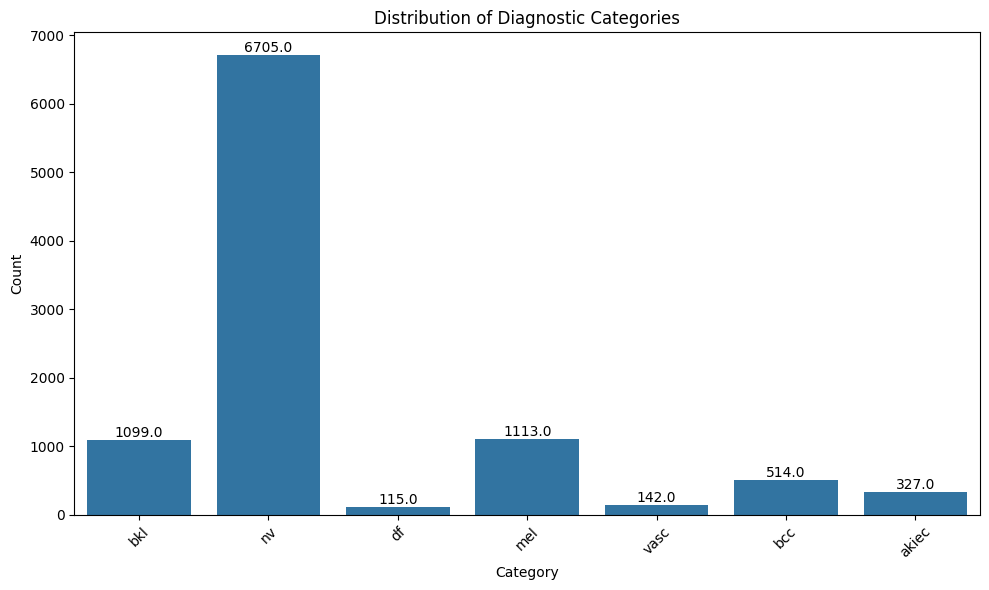


Age distribution:
Min age: 0.0, Max age: 85.0, Mean age: 51.86

Gender distribution:
sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64

Location of lesions:
localization
back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from PIL import Image
import cv2
from glob import glob

import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

from google.colab import drive;
drive.mount('/content/drive/')

# Define paths to your data
IMAGES_PATH_PART1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1"  # Adjust based on your folder structure
IMAGES_PATH_PART2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"  # Adjust based on your folder structure
METADATA_PATH = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"

# Load metadata
metadata = pd.read_csv(METADATA_PATH)

# Display basic information
print(f"Total number of images: {len(metadata)}")
print(f"Distribution of diagnostic categories:")
diagnosis_counts = metadata['dx'].value_counts()
print(diagnosis_counts)

# Check for missing values
print("\nMissing values:")
print(metadata.isnull().sum())

# Visualize class distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='dx', data=metadata)
plt.title('Distribution of Diagnostic Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Get diagnostic category descriptions
categories = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses / Intraepithelial carcinoma',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Add full category names to metadata
metadata['dx_name'] = metadata['dx'].map(categories)

# Display more metadata characteristics
print("\nAge distribution:")
print(f"Min age: {metadata['age'].min()}, Max age: {metadata['age'].max()}, Mean age: {metadata['age'].mean():.2f}")

print("\nGender distribution:")
print(metadata['sex'].value_counts())

print("\nLocation of lesions:")
print(metadata['localization'].value_counts())

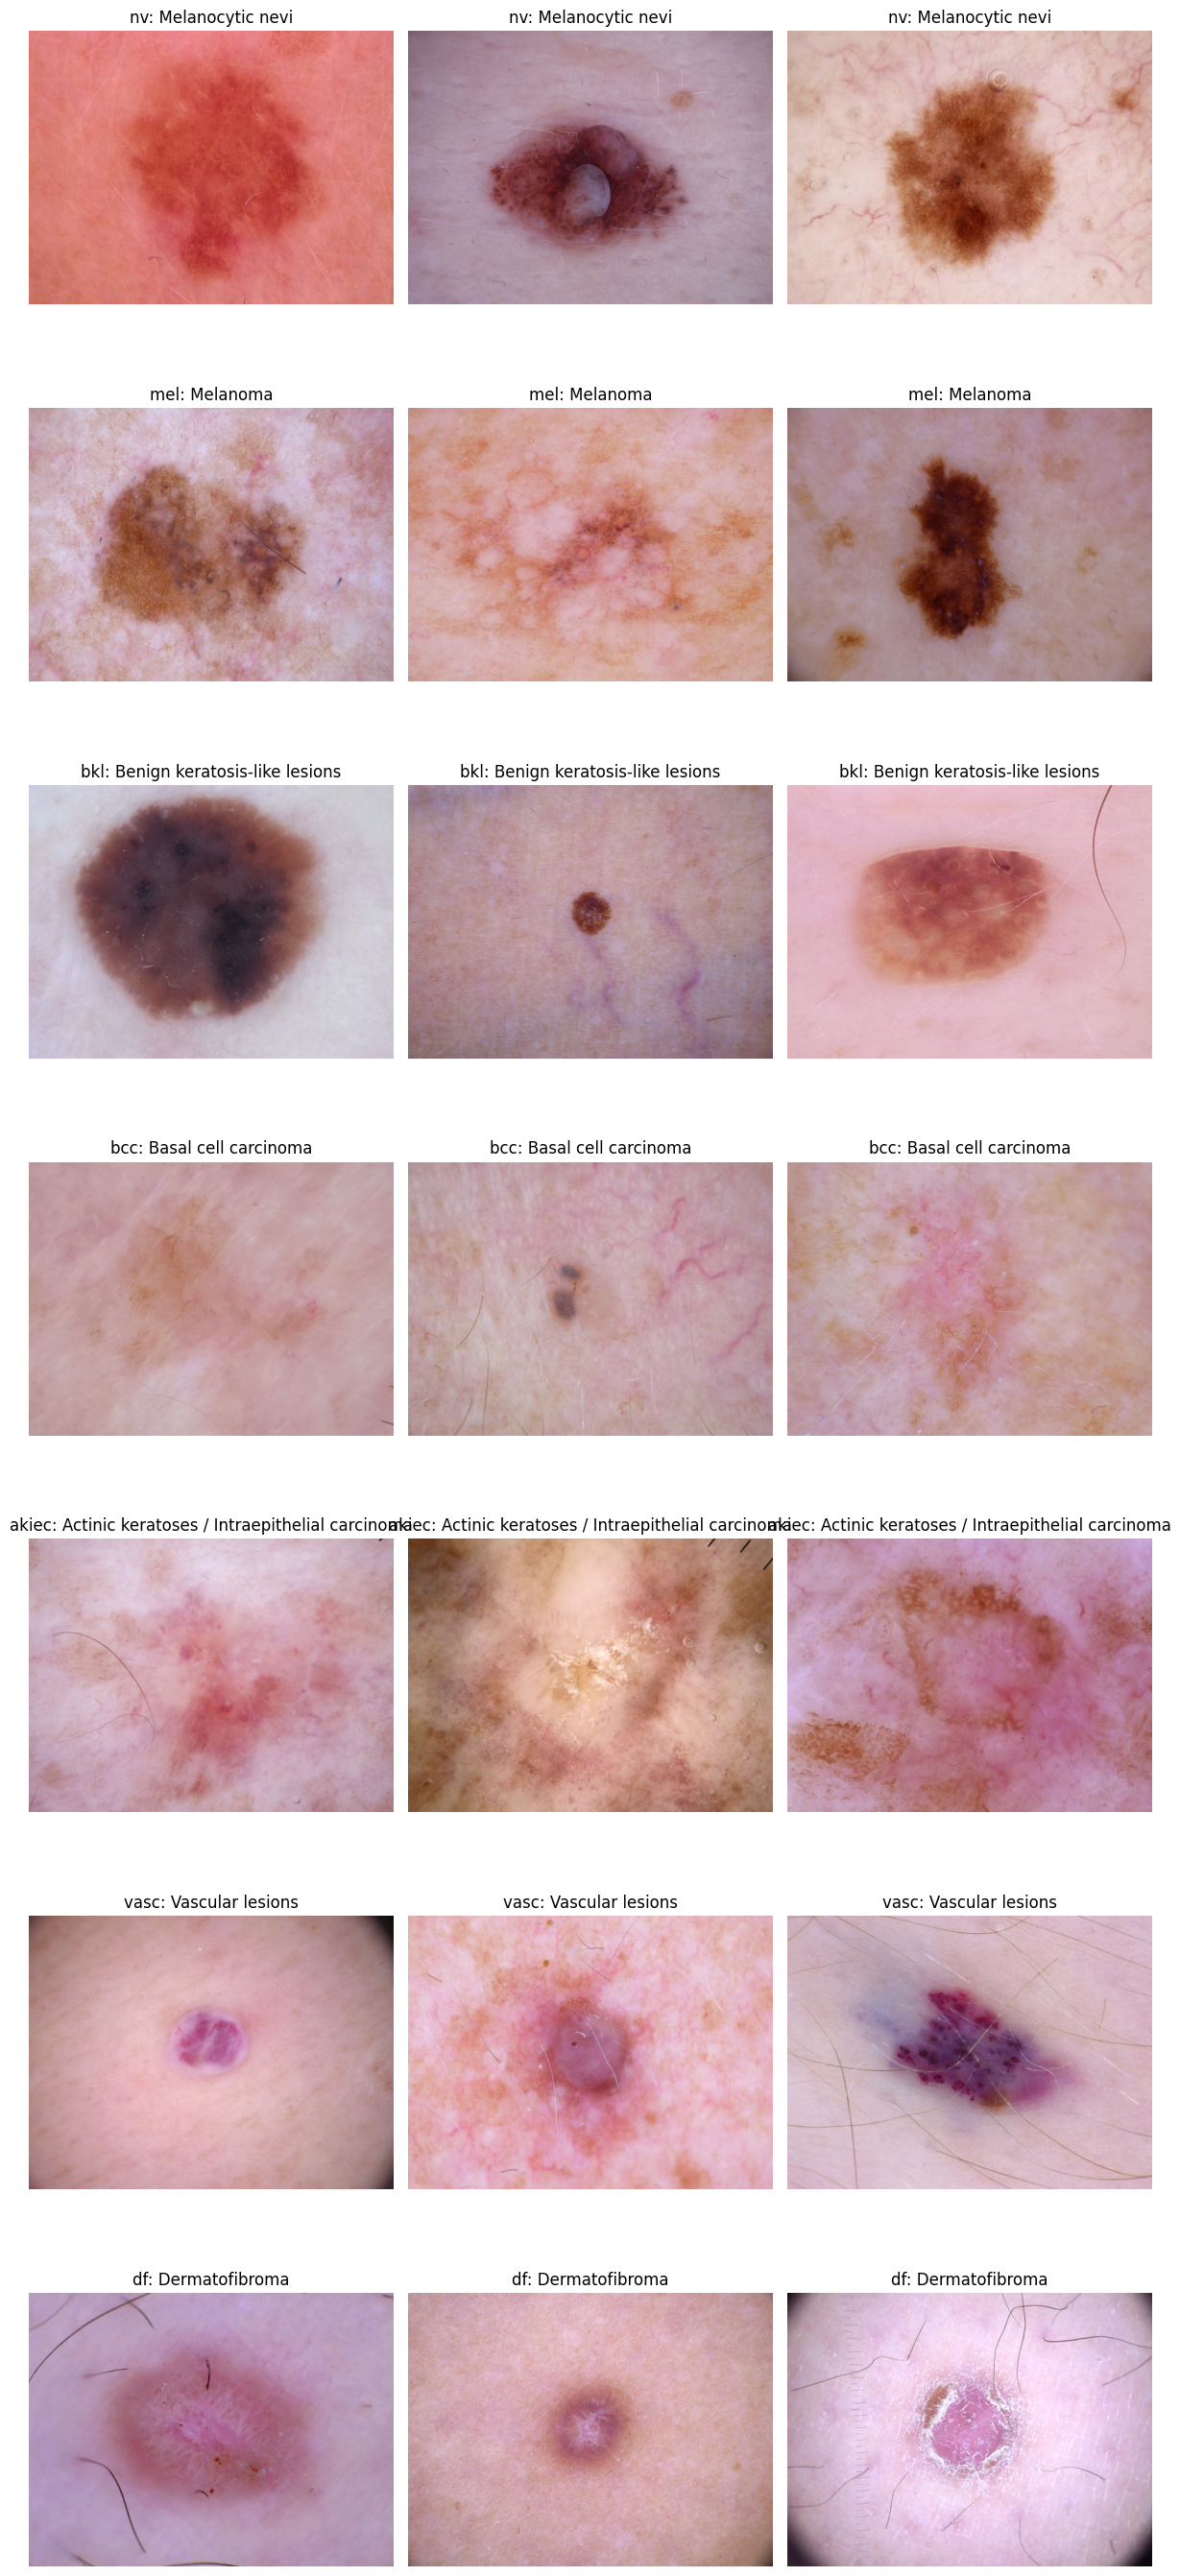

In [ ]:
# Function to find image path from image_id
def find_image_path(image_id, part1_path, part2_path):
    # Check in part 1
    possible_files = glob(os.path.join(part1_path, f"*{image_id}*"))
    if possible_files:
        return possible_files[0]

    # Check in part 2
    possible_files = glob(os.path.join(part2_path, f"*{image_id}*"))
    if possible_files:
        return possible_files[0]

    return None

# Function to display sample images from each category
def show_sample_images(metadata, categories, part1_path, part2_path, n_samples=3):
    plt.figure(figsize=(4*n_samples, 4*len(categories)))

    for i, category in enumerate(categories.keys()):
        category_samples = metadata[metadata['dx'] == category].sample(min(n_samples, len(metadata[metadata['dx'] == category])))

        for j, (_, row) in enumerate(category_samples.iterrows()):
            img_id = row['image_id']
            img_path = find_image_path(img_id, part1_path, part2_path)

            if img_path:
                img = Image.open(img_path)
                plt.subplot(len(categories), n_samples, i*n_samples + j + 1)
                plt.imshow(np.array(img))
                plt.title(f"{category}: {categories[category]}")
                plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display samples
show_sample_images(metadata, categories, IMAGES_PATH_PART1, IMAGES_PATH_PART2)

# If the above doesn't work due to filename format, try this alternative approach:
def show_sample_images_alt(metadata, categories, part1_path, part2_path, n_samples=3):
    # Get all image files from both directories
    all_files_part1 = glob(os.path.join(part1_path, "*.*"))
    all_files_part2 = glob(os.path.join(part2_path, "*.*"))
    all_files = all_files_part1 + all_files_part2

    # Create a dictionary of image_id to file path
    image_paths = {}
    for file_path in all_files:
        file_name = os.path.basename(file_path)
        # Extract image_id from filename (assuming ISIC_xxxxxxx.jpg format)
        if file_name.startswith("ISIC_"):
            image_id = file_name.split(".")[0]
            image_paths[image_id] = file_path

    plt.figure(figsize=(4*n_samples, 4*len(categories)))

    for i, category in enumerate(categories.keys()):
        category_samples = metadata[metadata['dx'] == category].sample(min(n_samples, len(metadata[metadata['dx'] == category])))

        for j, (_, row) in enumerate(category_samples.iterrows()):
            img_id = row['image_id']
            if img_id in image_paths:
                img_path = image_paths[img_id]
                img = Image.open(img_path)
                plt.subplot(len(categories), n_samples, i*n_samples + j + 1)
                plt.imshow(np.array(img))
                plt.title(f"{category}: {categories[category]}")
                plt.axis('off')

    plt.tight_layout()
    plt.show()

# Try this alternative function if the first one doesn't work
# show_sample_images_alt(metadata, categories, IMAGES_PATH_PART1, IMAGES_PATH_PART2)

In [ ]:
# Setup a basic image preprocessing function
def preprocess_image(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, target_size)  # Resize
    img = img / 255.0  # Normalize
    return img

# Example of preprocessing a single image
# sample_img_path = find_image_path(metadata.iloc[0]['image_id'], IMAGES_PATH_PART1, IMAGES_PATH_PART2)
# if sample_img_path:
#     processed_img = preprocess_image(sample_img_path)
#     plt.imshow(processed_img)
#     plt.title("Preprocessed Image")
#     plt.axis('off')
#     plt.show()

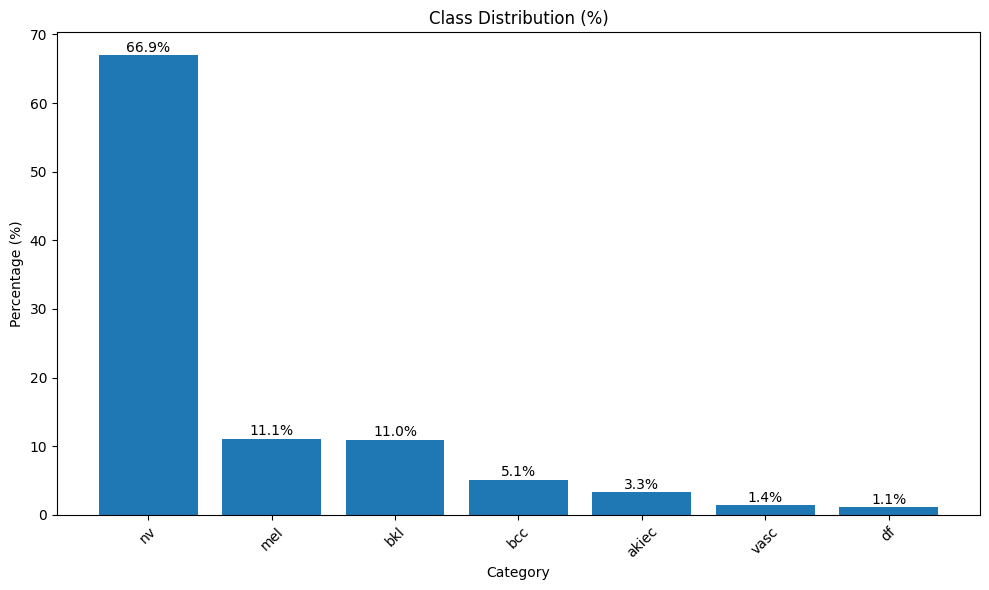

Class imbalance summary:
Melanocytic nevi: 6705 images (66.9%)
Melanoma: 1113 images (11.1%)
Benign keratosis-like lesions: 1099 images (11.0%)
Basal cell carcinoma: 514 images (5.1%)
Actinic keratoses / Intraepithelial carcinoma: 327 images (3.3%)
Vascular lesions: 142 images (1.4%)
Dermatofibroma: 115 images (1.1%)


In [ ]:
# Analyze class imbalance
plt.figure(figsize=(10, 6))
class_counts = metadata['dx'].value_counts()
class_percentages = 100 * class_counts / len(metadata)

plt.bar(class_counts.index, class_percentages)
plt.title('Class Distribution (%)')
plt.xlabel('Category')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)

# Add percentage labels
for i, p in enumerate(class_percentages):
    plt.text(i, p + 0.5, f'{p:.1f}%', ha='center')

plt.tight_layout()
plt.show()

print("Class imbalance summary:")
for dx, count in class_counts.items():
    print(f"{categories[dx]}: {count} images ({count/len(metadata)*100:.1f}%)")